In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import copy
import time
import random

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns
sns.set_style('darkgrid')

from scipy import stats

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, r2_score

import category_encoders as ce


SEED = 1337

# EDA

Let's start with data mining:

In [ ]:
raw = pd.read_table('ecommon_data.csv', delimiter=',', index_col='Unnamed: 0')
raw.drop(columns=['PROXI_CATEG3'], inplace=True)

raw.head()

test = pd.read_table('discount_for_202010.csv', delimiter=';')
test['DISCOUNT'] = test.DISCOUNT.map(lambda x: x.replace(',', '.')).astype('float')

In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135877 entries, 0 to 946349
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SHIP_TO   135877 non-null  object 
 1   SKU       135877 non-null  object 
 2   PGI_DATE  135877 non-null  int64  
 3   VOL       135877 non-null  float64
 4   DISCOUNT  135877 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.2+ MB


No data gaps

In [ ]:
raw.describe(include='all')

,SHIP_TO,SKU,PGI_DATE,VOL,DISCOUNT
count,135877,135877,1.358770e+05,135877.000000,135877.000000
unique,309,550,NaN,NaN,NaN
top,706155A5C878094F242F042F11C16B1A,F4655A2B707853F1B118E0DADC52F9BA,NaN,NaN,NaN
freq,12130,3064,NaN,NaN,NaN
mean,NaN,NaN,2.019682e+07,29.326639,2.592897
std,NaN,NaN,4.662385e+03,267.753829,6.651910
min,NaN,NaN,2.019040e+07,-7362.672000,0.000000
25%,NaN,NaN,2.019102e+07,4.144800,0.000000
50%,NaN,NaN,2.020041e+07,7.649040,0.000000
75%,NaN,NaN,2.020042e+07,17.521200,0.000000


For categorical features: date, point, product, we will need to encode them. Based on the tests, we decided to encode them using One-Hot Encoding, therefore, in order for the feature matrices to be of the same dimension, it is necessary to encode the combined train and test samples.

In [ ]:
merged = raw.append(test)
merged = pd.get_dummies(merged, columns=['PGI_DATE', 'SHIP_TO', 'SKU'])
raw = merged[:135877]
test = merged[135877:]
test.drop(columns=['VOL'], inplace=True)

#### Outliers in VOL column are too large

The outliers in VOL, however, are too large, we decided to get rid of them so that the model does not adjust for these outliers. On real data, most likely, the distribution would look approximately normal, so it would not be necessary to get rid of outliers.

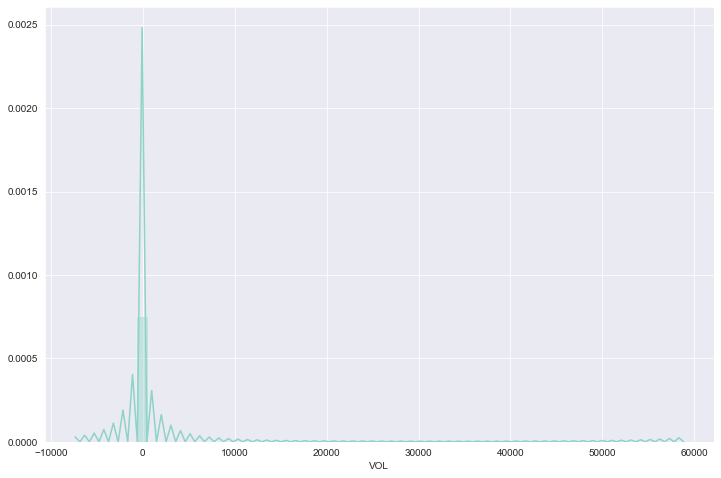

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(raw.VOL)
plt.show()

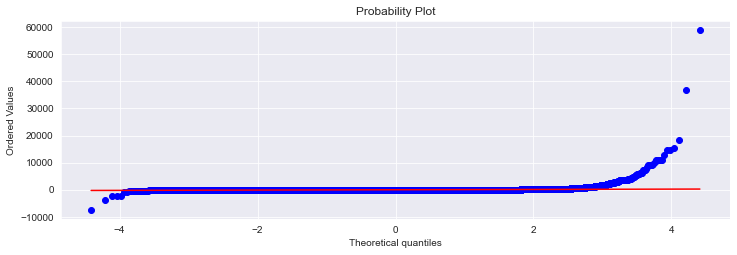

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
prob = stats.probplot(raw.VOL.values, dist=stats.norm, plot=ax1)

In [ ]:
Q1 = raw.VOL.quantile(0.25)
Q3 = raw.VOL.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

13.3764


In [ ]:
raw = raw[~((raw.VOL < (Q1 - 1.5 * IQR)) | (raw.VOL > (Q3 + 1.5 * IQR)))]

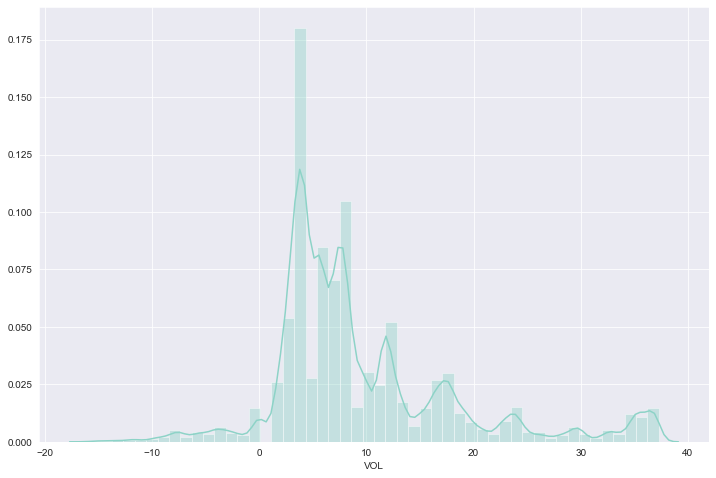

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(raw.VOL)
plt.show()

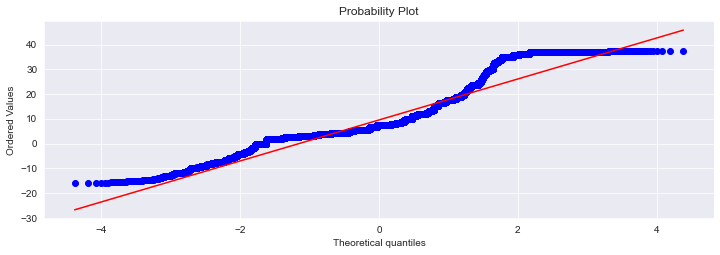

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
prob = stats.probplot(raw.VOL.values, dist=stats.norm, plot=ax2)

In [ ]:
# Describe the data now
raw.VOL.describe()

count    118640.000000
mean          9.555906
std           8.885571
min         -15.888400
25%           4.144800
50%           7.347600
75%          12.151800
max          37.303200
Name: VOL, dtype: float64

In [ ]:
# Separate target from features
y = raw.VOL
raw.drop(['VOL'], axis=1, inplace=True)

In [ ]:
# Divide the sample into train and test
X_train, X_test, y_train, y_test = train_test_split(
    raw, y,
    train_size=0.7,
    test_size=0.3,
    random_state=1337
)

In [ ]:
# divide test additionally into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test,
    train_size=0.5,
    test_size=0.5,
    random_state=1337
)

In [ ]:
# Scale data to the distribution with average 0 and standard deviation 1
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)
test = scaler.fit_transform(test)

In [ ]:
# Convert to tensors PyTorch
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_train_tensor = torch.from_numpy(y_train.values).float()
y_val_tensor = torch.from_numpy(y_val.values).float()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test.values).float()

test_tensor = torch.from_numpy(test).float()

# Create dataloaders
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)

dataloaders = {'train': data.DataLoader(train_dataset, batch_size=3000, shuffle=True, num_workers=2),
               'val': data.DataLoader(val_dataset, batch_size=3000, shuffle=True, num_workers=2)}

# Multilayer Perceptron

In [ ]:
class DanoNet(nn.Module):
    """
    Multilayer perceptron with Leaky ReLu and dropout.

     n_input(int): number of neurons in the input layer
     n_hidden (int list): list the number of neurons n_hidden[i] in the i-th hidden layer
     n_output (int): number of neurons in the output layer
     drop_p (float): dropout probability
    """
    def __init__(self, n_input, n_hidden, drop_p, random_state=SEED):
        super().__init__()
        self.random_state = random_state
        self.hidden_layers = nn.ModuleList([nn.Linear(n_input, n_hidden[0])])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in zip(n_hidden[:-1], n_hidden[1:])])
        self.output_layer = nn.Linear(n_hidden[-1], 1)
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, X):
        """Direct pass, count the output data"""
        for layer in self.hidden_layers:
            X = F.leaky_relu(layer(X))
            X = self.dropout(X)
        X = self.output_layer(X)
        return X

    def predict(self, X_test):
        return self.forward(X_test).detach().squeeze(1).cpu().numpy()

In [ ]:
def train(model, epochs, criterion, optimizer, scheduler, dataloaders, verbose=False):
    """
    Model training

     model: training model
     epochs (int): number of epochs
     criterion: loss function
     optimizer: optimizer
     scheduler: learning rate scheduler
     dataloaders: data loaders for training and validation
     verbose (bool): print training details (elapsed tense and loss)
    """

    t0_tot = time.time()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device}")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    losses = {'train': [], 'val': []}
    rmse_values = []
    mae_values = []
    r2_values = []

    for epoch in range(epochs):
        t0 = time.time()
        print(f"============== Epoch {epoch + 1}/{epochs} ==============")
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                if verbose:
                    print(f"lr: {scheduler.get_lr()}")
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for ii, (X_batch, y_batch) in enumerate(dataloaders[phase], start=1):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(X_batch).squeeze(1)
                    loss = criterion(outputs, y_batch)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * X_batch.shape[0]

            ep_loss = running_loss / len(dataloaders[phase].dataset)
            losses[phase].append(ep_loss)
            if verbose:
                print(f"({phase}) Loss: {ep_loss:.5f}")

            if phase == 'val' and ep_loss < best_loss:
                best_loss = ep_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        rmse = mean_squared_error(dataloaders['val'].dataset.tensors[1].numpy(),
                    model.predict(dataloaders['val'].dataset.tensors[0].to(device)), squared=True)
        rmse_values.append(rmse)
        mae = mean_absolute_error(dataloaders['val'].dataset.tensors[1].numpy(),
                    model.predict(dataloaders['val'].dataset.tensors[0].to(device)))
        mae_values.append(mae)
        r2 = r2_score(dataloaders['val'].dataset.tensors[1].numpy(),
                    model.predict(dataloaders['val'].dataset.tensors[0].to(device)))
        r2_values.append(r2)

        if verbose:
            print(f"(val) RMSE: {rmse}")
            print(f"(val) MAE: {mae}")
            print(f"(val) R2: {r2}")
            print(f"\nElapsed time: {round(time.time()-t0, 2)} sec\n")

    print(f"\nTraining completed in {round(time.time()-t0_tot, 2)} sec")

    model.load_state_dict(best_model_wts)
    model.losses = losses
    model.rmse_values = rmse_values
    model.mae_values = mae_values
    model.r2_values = r2_values
    model.to('cpu')
    model.eval()

    return model


def plot_losses(train_losses, val_losses):
    y = [train_losses, val_losses]
    c = ['C7', 'C9']
    labels = ['Train loss', 'Validation loss']

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = list(range(1, len(train_losses)+1))

    for i in range(2):
        ax.plot(x, y[i], lw=3, label=labels[i], color=c[i])
        ax.set_xlabel('Epoch', fontsize=16)
        ax.set_ylabel('Loss', fontsize=16)
        ax.set_xticks(range(0, x[-1]+1, 2))
        ax.legend(loc='best')
    plt.tight_layout()
    plt.show()


def plot_rmse(rmse_values):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = list(range(1, len(rmse_values)+1))

    ax.plot(x, rmse_values, lw=3, color='C6')
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('RMSE', fontsize=16)
    ax.set_xticks(range(0, x[-1]+1, 2))
    plt.tight_layout()
    plt.show()


def plot_mae(mae_values):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = list(range(1, len(mae_values)+1))

    ax.plot(x, mae_values, lw=3, color='C6')
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('MAE', fontsize=16)
    ax.set_xticks(range(0, x[-1]+1, 2))
    plt.tight_layout()
    plt.show()


def plot_r2(r2_values):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = list(range(1, len(r2_values)+1))

    ax.plot(x, r2_values, lw=3, color='C6')
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('R^2 Score', fontsize=16)
    ax.set_xticks(range(0, x[-1]+1, 2))
    plt.tight_layout()
    plt.show()

In [ ]:
danonet = DanoNet(n_input=X_train.shape[1], n_hidden=[300, 200, 100], drop_p=0.4)

criterion = nn.MSELoss()
optimizer = optim.Adam(danonet.parameters(), lr=0.01, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 30

In [ ]:
train(danonet, epochs, criterion, optimizer, scheduler, dataloaders, verbose=True)

Training on cuda
============== Epoch 1/30 ==============
lr: [0.01]
(train) Loss: 61.92148
(val) Loss: 37.74994
(val) RMSE: 37.749942779541016
(val) MAE: 4.163487911224365
(val) R2: 0.5347158863071465

Elapsed time: 3.37 sec

============== Epoch 2/30 ==============
lr: [0.01]
(train) Loss: 38.89948
(val) Loss: 36.19671
(val) RMSE: 36.19670867919922
(val) MAE: 4.016976356506348
(val) R2: 0.5538601100043403

Elapsed time: 2.98 sec

============== Epoch 3/30 ==============
lr: [0.01]
(train) Loss: 36.93914
(val) Loss: 35.72274
(val) RMSE: 35.72273635864258
(val) MAE: 3.951401472091675
(val) R2: 0.5597020304966334

Elapsed time: 3.09 sec

============== Epoch 4/30 ==============
lr: [0.01]
(train) Loss: 35.63404
(val) Loss: 35.45784
(val) RMSE: 35.45783996582031
(val) MAE: 3.8385539054870605
(val) R2: 0.5629670327287053

Elapsed time: 2.93 sec

============== Epoch 5/30 ==============
lr: [0.0001]
(train) Loss: 33.19982
(val) Loss: 33.26617
(val) RMSE: 33.26617431640625
(val) MAE: 3.7290

DanoNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1244, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

After the 14th epoch, the model no longer provides significant improvements in results. MAE is only ~3.5, the model explains ~61% of the variance.

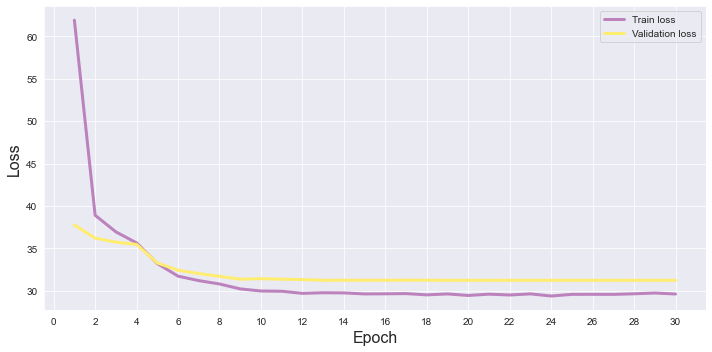

In [ ]:
plot_losses(danonet.losses['train'], danonet.losses['val'])

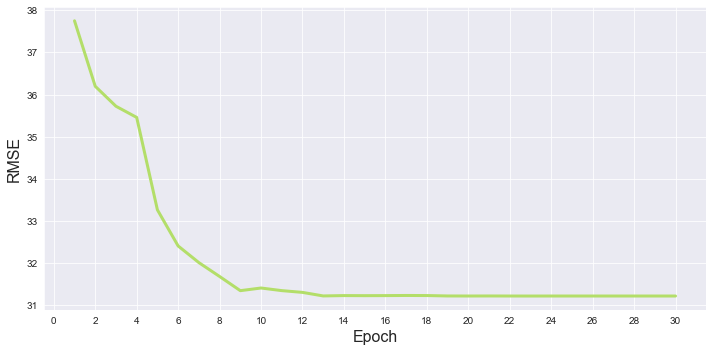

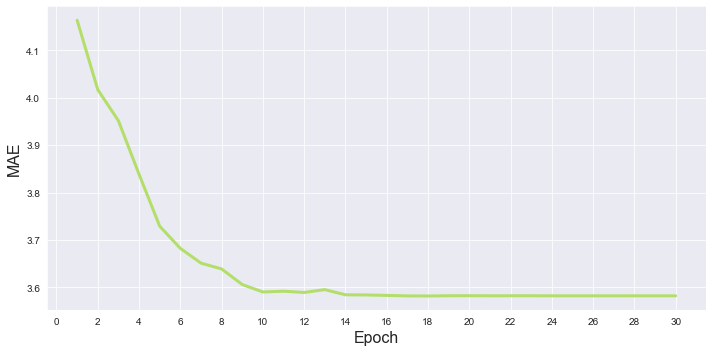

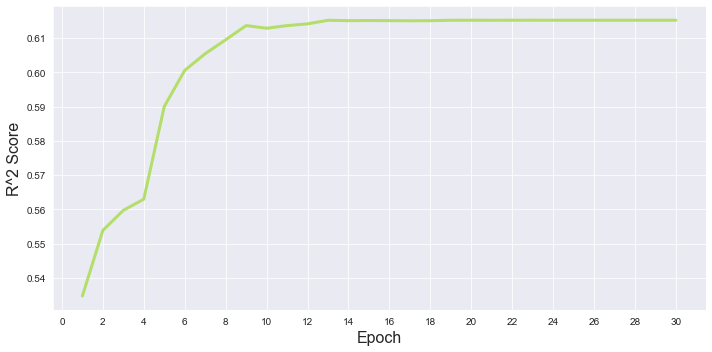

In [ ]:
plot_rmse(danonet.rmse_values)
plot_mae(danonet.mae_values)
plot_r2(danonet.r2_values)

In [ ]:
# Save the model
torch.save(danonet.state_dict(), 'danonet.pth')

In [ ]:
danonet = DanoNet(n_input=X_train.shape[1], n_hidden=[300, 200, 100], drop_p=0.4)
danonet.load_state_dict(torch.load('danonet.pth'))
danonet.eval()

DanoNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1244, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
# Get predictions
danonet_pred = danonet.predict(test_tensor)

In [ ]:
# Form results
test = pd.read_table('discount_for_202010.csv', delimiter=';')
test.drop(columns=['DISCOUNT'], inplace=True)
test['FORECAST_VOL'] = danonet_pred
team = np.array(['TEAM_56']).repeat(57645)
test['TEAM'] = team
test.to_csv('team56_forecast.csv', sep=';')

test.head()

,PGI_DATE,SHIP_TO,SKU,FORECAST_VOL,TEAM
0,20201001,5CF75D24155048112638F87DB1D1226C,7DFA4250D2207EEB61883DDF5B67A1A7,2.714166,TEAM_56
1,20201001,5CF75D24155048112638F87DB1D1226C,F2B3E6A656C805BF1CEB1FC5734E7622,2.283660,TEAM_56
2,20201001,5CF75D24155048112638F87DB1D1226C,8266B80A417D8DF4267AA877838FBBFA,1.025540,TEAM_56
3,20201001,5CF75D24155048112638F87DB1D1226C,37E9B839EEB8B2D3C484E37C548DCCAE,5.434736,TEAM_56
4,20201001,5CF75D24155048112638F87DB1D1226C,32CD0B3CFED084C5C03F6AAFA0BB8D13,5.606450,TEAM_56


On average, we have an idea that by October 2020 sales will decrease slightly, as expected:

In [ ]:
test.FORECAST_VOL.describe()

count    57645.000000
mean         6.083074
std          8.113597
min         -0.705594
25%          1.533351
50%          2.764344
75%          7.316505
max        158.123123
Name: FORECAST_VOL, dtype: float64